In [1]:
# Fuseki IO Development V
## Refinement

# Attach dir one above to handle IDE subdir
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import repository
from rdflib import URIRef, Graph, Namespace, Literal


import pandas as pd
import html
import io
import pydotplus
from rdflib.tools.rdf2dot import rdf2dot
from IPython.display import display, Image
from urllib.error import HTTPError

from datetime import datetime

start = datetime.now()
import text_utils

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation
* Owlready2 * WARNING: ObjectProperty http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#MappingMetaTarget belongs to more than one entity types: [owl.AnnotationProperty, owl.ObjectProperty, owl.topObjectProperty]; I'm trying to fix it...
* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /home/tomk/environment/devpy/lib/python3.10/site-packages/owlready2/hermit:/home/tomk/environment/devpy/lib/python3.10/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmp6zwpbf0r


Serialization.Meta [Serialization.SerializationMetaData]
Serialization.TranslationMapping [Serialization.SerializationSpecs]
Serialization.MappingKVPair [Serialization.SerializationSpecs]
Serialization.Serialization [Serialization.SerializationSpecs]
Serialization.Mapping [Serialization.SerializationSpecs]
Serialization.BatchDefinition [Serialization.SerializationSpecs]
Serialization.SerializationSpecs [Serialization.SerializationMetaData]
Serialization.BatchNode [Serialization.DataLoad]
Serialization.DataLoad [Serialization.SerializationMetaData]
Serialization.SerializationMetaData [owl.Thing]
Serialization.DataPropertyMapping [Serialization.Mapping]
Serialization.MetaDataProperty [Serialization.Meta]
Serialization.EntityMapping [Serialization.Mapping]
Serialization.MetaClass [Serialization.Meta]
Serialization.JobNode [Serialization.DataLoad]
Serialization.MetaProperty [Serialization.Meta]
Serialization.MetaStaticProperty [Serialization.Meta]
Serialization.PropertyMapping [Serializati

* Owlready2 * HermiT took 0.6177067756652832 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [41]:
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    #print(stream.getvalue())
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()

    display(Image(png))

def t2rdflibg(triples): #triples to rdflib graph
    g = Graph()
    for t in triples:
        g.add(t)
    return g

def get_field(v):
    if isinstance(v,str):
        return html.escape(str(v))
    elif isinstance(v,(int, float)):
        if pd.isnull(v):
            return None
        else:
            return v
    elif v is None or isinstance(v,pd.Null):
        return None
    
def un_rdflib(value):
    if isinstance(value, URIRef):                  
        return value.n3()[1:-1]
    elif isinstance(value, Literal):
        return value.toPython()
    else:
        return value

def flatten_rdflib_query_results(query_results):
    for row in query_results:
        yield {query_results.vars[e].toPython()[1:]:un_rdflib(v) for e,v in enumerate(row)}
    

In [3]:
store_type="jena"
store_type="memory"
repo = repository.Repository(store_type=store_type)

In [4]:
# Optional Delete data hosted in master and discourse database graphs
do="Yes"
#do="No"

if do == "Yes" and store_type != "memory":
    try:
        repo.truncate_graph("""<http://master>""")
    except HTTPError:
        pass

    try:
                repo.truncate_graph("""<http://discourse>""")
    except HTTPError:
        pass


In [5]:
discourse_details_sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> 
PREFIX dcterms: <http://purl.org/dc/terms/> 
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 

select ?g ?discourse ?name ?title ?description ?created ?hash (COUNT(?declaration) as ?declarations) (COUNT(distinct ?psubject) as ?entities)

WHERE {
  GRAPH ?g
  {
      ?discourse a disco:Discourse.
      ?discourse dcterms:title ?title.
      ?discourse rdfs:label ?name.
      ?discourse dcterms:description ?description.
      ?discourse dcterms:created ?created .
      ?discourse disco:DiscourseHash ?hash .
      ?discourse disco:DiscourseContains+ ?declaration .
      ?declaration a disco:Declaration .
      ?posit_type rdfs:subPropertyOf* disco:Posits .
      ?declaration disco:Asserts ?assertion.
      ?assertion disco:Subject ?psubject.
  }
}
GROUP BY ?g ?discourse ?name ?title ?description ?created ?hash
"""

qr = repo.ds.query(discourse_details_sparql)
pd.DataFrame(qr)

""


In [6]:
list(repo._flatten_rdflib_query_results(qr))

[]

In [7]:
repo.discourse_hashes

[]

In [8]:
repo.register_serialization("../sample_ser.rdf")

In [9]:
mpd = {"created" : "2023-08-17", 
       "creator" : "tomk", 
       "description" : "Test sample serialization", 
       "title" : "test3", 
       "modified" : "2023-04-10"}
metadata_payload = repo.meta_data_package_template( mpd )

datarows=[{"ParentClass" : "Y6AF", 
       "Class" : "Fred Kimber", 
       "SubClassPointer" : "b", 
       "Property" : "Sebastian", 
       "DataProperty" : "Cyan"},
      
       {"ParentClass" : "Y6AF", 
       "Class" : "Sebastian", 
       "SubClassPointer" : "c", 
       "Property" : "Manuel", 
       "DataProperty" : "Green"},
      
       {"ParentClass" : "Y6AF", 
       "Class" : "Manuel", 
       "SubClassPointer" : "a", 
       "Property" : "Fred Kimber", 
       "DataProperty" : "Red"}
]


repo.load_serialization_to_discourse("Sample Serialisation", mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.009942 for 21 from 3
//////LOCATE2/////
self.members: 21
0:00:00.027943 for 282 triples


In [10]:
repo.discourse_hashes

[('ec4a9c21e274-4192-9e5c-5a8937ae638a',
  'http://www.semanticweb.org/tomk/ontologies/2022/11/02cfd8479881448a9cb1d60e0623210f')]

In [11]:
repo.load_serialization_to_discourse("Sample Serialisation", mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.010120 for 21 from 3
//////LOCATE2/////
self.members: 21
This data is already loaded! - Aborting


In [12]:
repo.load_serialization_to_discourse("Sample Serialisation", mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.008908 for 21 from 3
//////LOCATE2/////
self.members: 21
This data is already loaded! - Aborting


In [13]:
repo.discourse_hashes

[('ec4a9c21e274-4192-9e5c-5a8937ae638a',
  'http://www.semanticweb.org/tomk/ontologies/2022/11/02cfd8479881448a9cb1d60e0623210f')]

In [14]:
repo.discourse_hashes

[('ec4a9c21e274-4192-9e5c-5a8937ae638a',
  'http://www.semanticweb.org/tomk/ontologies/2022/11/02cfd8479881448a9cb1d60e0623210f')]

In [15]:
with open("../SPARQL/get_discourse_posits_parms_discourse_iris.sparql", "r") as f:
    sparql=f.read()

In [16]:
get_posits_sparql = sparql.replace("%%p0%%", URIRef(repo.discourse_hashes[0][1]).n3())

In [17]:
get_posits_sparql

'PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> \nPREFIX dcterms: <http://purl.org/dc/terms/> \nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> \n\nselect ?g ?discourse ?assertion ?refutation ?posit ?s ?p ?o\nWHERE {\n  GRAPH ?g\n  {\n      ?discourse a disco:Discourse.\n      ?discourse disco:DiscourseContains+ ?declaration .\n      ?declaration a disco:Declaration .\n        OPTIONAL { ?declaration disco:Asserts ?assertion. \n                   ?assertion disco:Subject ?s.\n                   ?assertion disco:Predicate ?p.\n                   ?assertion disco:Object ?o.\n                   }\n        OPTIONAL { ?declaration disco:Refutes ?refutation. \n                   ?refutation disco:Subject ?s.\n                   ?refutation disco:Predicate ?p.\n                   ?refutation disco:Object ?o.\n                   }\n        OPTIONAL { ?declaration disco:Posits ?posit. \n              

In [18]:
qr = repo.ds.query(get_posits_sparql)

In [19]:
results = list([{k:v[e] for e,k in enumerate([v.n3()[1:] for v in qr.vars])} for v in qr])
dcontents = pd.DataFrame(results)
dcontents['triple'] = dcontents.apply(lambda x : tuple([x['s'], x['p'], x['o']]), axis=1)
dcd = dcontents.groupby(['discourse'])['triple'].agg(set).to_dict()
s1 = list(dcd.values())[0]

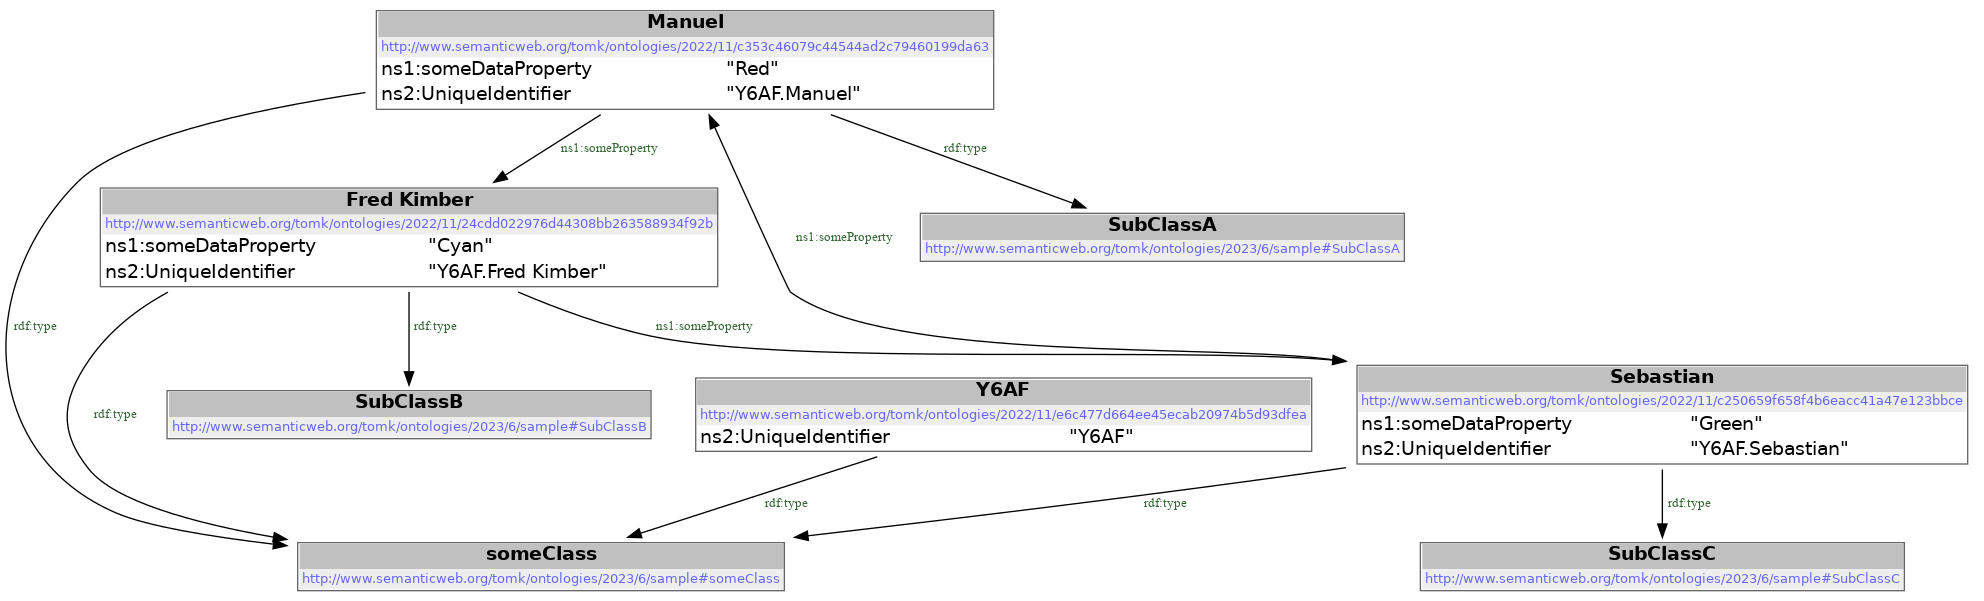

In [20]:
visualize(t2rdflibg(s1))

In [21]:
repo.register_serialization("../DMEAR_ser.rdf")

In [22]:
file_dtypes = {'ModelDomain': str,
 'Model': str,
 'ModelType': str,
 'Class': str,
 'ClassDescription': str,
 'Attribute': str,
 'AttributeDescription': str,
 'DataType': str,
 'Context': str,
 'SubContext': str,
 'Nulls': str,
 'IsPK': str,
 'Relationship': str,
 'FromClass': str,
 'FromAttribute': str,
 'FromCardinality': str,
 'ToClass': str,
 'ToAttribute': str,
 'ToCardinality': str}
mpd = {"created" : "2023-04-10", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 1", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-10"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v1.0"
model_data = pd.read_csv(r"../sample/inventory_v1.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
repo.load_serialization_to_discourse("Data Model Entity Attribute Relation Serialization", mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.019665 for 93 from 9
//////LOCATE2/////
self.members: 93
0:00:00.076590 for 1218 triples


In [23]:
mpd = {"created" : "2023-04-10", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 2", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-10"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v2.0"
model_data = pd.read_csv(r"../sample/inventory_v2.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
repo.load_serialization_to_discourse("Data Model Entity Attribute Relation Serialization", mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.032133 for 177 from 18
//////LOCATE2/////
self.members: 177
0:00:00.193326 for 2310 triples


In [24]:
mpd = {"created" : "2023-04-10", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 3", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-10"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v3.0"
model_data = pd.read_csv(r"../sample/inventory_v3.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
repo.load_serialization_to_discourse("Data Model Entity Attribute Relation Serialization", mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.066902 for 412 from 44
//////LOCATE2/////
self.members: 412
0:00:00.277463 for 5365 triples


In [25]:
mpd = {"created" : "2023-04-10", 
                   "creator" : "tomk", 
                   "description" : "Sample ERD model version 4", 
                   "title" : "inventory ERD", 
                   "modified" : "2023-04-10"}
metadata_payload = repo.meta_data_package_template( mpd )
title = "Inventory ERD v4.0"
model_data = pd.read_csv(r"../sample/inventory_v4.csv", index_col="Sequence", dtype=file_dtypes)
datarows = [dict({rk:get_field(rv) for rk, rv in r.items()}) for i,r in model_data.iterrows()]
repo.load_serialization_to_discourse("Data Model Entity Attribute Relation Serialization", mpd['title'], metadata_payload, datarows)

//////LOCATE1/////
0:00:00.073556 for 439 from 47
//////LOCATE2/////
self.members: 439
0:00:00.366304 for 5716 triples


In [26]:
repo.discourse_hashes

[('ec4a9c21e274-4192-9e5c-5a8937ae638a',
  'http://www.semanticweb.org/tomk/ontologies/2022/11/02cfd8479881448a9cb1d60e0623210f'),
 ('7adbc4147ada-d54b-17d1-e6c6058a5928',
  'http://www.semanticweb.org/tomk/ontologies/2022/11/dbeda14020a14e98a388b2a692f24e10'),
 ('d9620a8c27fc-0271-7079-d4fbe93ad57b',
  'http://www.semanticweb.org/tomk/ontologies/2022/11/64981c67de7c4a29b86c62d5a1eb19c3'),
 ('f5582939cc55-90fc-83a4-dda4536cec3b',
  'http://www.semanticweb.org/tomk/ontologies/2022/11/823ddfbc71de40c79eba1bd3e384de51'),
 ('4eaecc19b060-3712-ac8e-999ffccc709d',
  'http://www.semanticweb.org/tomk/ontologies/2022/11/f5b1f5fcc6e44221a743e3d06b8d043b')]

In [42]:
qr_iter = flatten_rdflib_query_results(qr)

list(qr_iter)

[{'g': 'http://discourse',
  'discourse': 'http://www.semanticweb.org/tomk/ontologies/2022/11/02cfd8479881448a9cb1d60e0623210f',
  'name': 'discourse_test3',
  'title': 'test3',
  'description': 'Test sample serialization',
  'created': '2023-08-17',
  'hash': 'ec4a9c21e274-4192-9e5c-5a8937ae638a',
  'declarations': 21,
  'entities': 4},
 {'g': 'http://discourse',
  'discourse': 'http://www.semanticweb.org/tomk/ontologies/2022/11/dbeda14020a14e98a388b2a692f24e10',
  'name': 'discourse_inventory ERD',
  'title': 'inventory ERD',
  'description': 'Sample ERD model version 1',
  'created': '2023-04-10',
  'hash': '7adbc4147ada-d54b-17d1-e6c6058a5928',
  'declarations': 93,
  'entities': 13},
 {'g': 'http://discourse',
  'discourse': 'http://www.semanticweb.org/tomk/ontologies/2022/11/64981c67de7c4a29b86c62d5a1eb19c3',
  'name': 'discourse_inventory ERD',
  'title': 'inventory ERD',
  'description': 'Sample ERD model version 2',
  'created': '2023-04-10',
  'hash': 'd9620a8c27fc-0271-7079-

In [43]:
qr = repo.ds.query(discourse_details_sparql)
qr_iter = flatten_rdflib_query_results(qr)
qr_df = pd.DataFrame(qr_iter)

In [44]:
qr_df

,g,discourse,name,title,description,created,hash,declarations,entities
0,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_test3,test3,Test sample serialization,2023-08-17,ec4a9c21e274-4192-9e5c-5a8937ae638a,21,4
1,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_inventory ERD,inventory ERD,Sample ERD model version 1,2023-04-10,7adbc4147ada-d54b-17d1-e6c6058a5928,93,13
2,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_inventory ERD,inventory ERD,Sample ERD model version 2,2023-04-10,d9620a8c27fc-0271-7079-d4fbe93ad57b,177,24
3,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_inventory ERD,inventory ERD,Sample ERD model version 3,2023-04-10,f5582939cc55-90fc-83a4-dda4536cec3b,412,56
4,http://discourse,http://www.semanticweb.org/tomk/ontologies/202...,discourse_inventory ERD,inventory ERD,Sample ERD model version 4,2023-04-10,4eaecc19b060-3712-ac8e-999ffccc709d,439,59


In [45]:
qi = qr_df.query("description in ['Sample ERD model version 3', 'Sample ERD model version 4'] ").index.values

In [46]:
d1 = URIRef(qr_df.iloc[qi[0]]['discourse']).n3()
d2 = URIRef(qr_df.iloc[qi[1]]['discourse']).n3()
get_posits_sparql = sparql.replace("%%p0%%", ",".join([d1,d2]))

d1,d2,get_posits_sparql

('<http://www.semanticweb.org/tomk/ontologies/2022/11/823ddfbc71de40c79eba1bd3e384de51>',
 '<http://www.semanticweb.org/tomk/ontologies/2022/11/f5b1f5fcc6e44221a743e3d06b8d043b>',
 'PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX disco: <http://www.semanticweb.org/tomk/ontologies/2022/11/discourse#> \nPREFIX dcterms: <http://purl.org/dc/terms/> \nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> \n\nselect ?g ?discourse ?assertion ?refutation ?posit ?s ?p ?o\nWHERE {\n  GRAPH ?g\n  {\n      ?discourse a disco:Discourse.\n      ?discourse disco:DiscourseContains+ ?declaration .\n      ?declaration a disco:Declaration .\n        OPTIONAL { ?declaration disco:Asserts ?assertion. \n                   ?assertion disco:Subject ?s.\n                   ?assertion disco:Predicate ?p.\n                   ?assertion disco:Object ?o.\n                   }\n        OPTIONAL { ?declaration disco:Refutes ?refutation. \n                   ?refutation disco:Subject ?s.\n           

In [47]:

qr = repo.ds.query(get_posits_sparql)
results = list([{k:v[e] for e,k in enumerate([v.n3()[1:] for v in qr.vars])} for v in qr])
dcontents = pd.DataFrame(results)
set(dcontents['p'])


{rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Contains'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#DataType'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Description'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#FromCardinality'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#ModelType'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Optionality'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromAttribute'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromClass'),
 rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToAttribute')

In [48]:

dcontents['triple'] = dcontents.apply(lambda x : tuple([x['s'], x['p'], x['o']]), axis=1)
dcd = dcontents.groupby(['discourse'])['triple'].agg(set).to_dict()

In [49]:
d1, d2

('<http://www.semanticweb.org/tomk/ontologies/2022/11/823ddfbc71de40c79eba1bd3e384de51>',
 '<http://www.semanticweb.org/tomk/ontologies/2022/11/f5b1f5fcc6e44221a743e3d06b8d043b>')

In [50]:
from rdflib.util import from_n3
from_n3(d1)

rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/823ddfbc71de40c79eba1bd3e384de51')

In [51]:
dcd.keys()

dict_keys([rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/823ddfbc71de40c79eba1bd3e384de51'), rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/f5b1f5fcc6e44221a743e3d06b8d043b')])

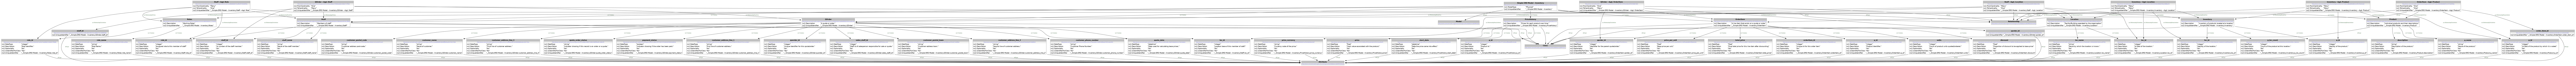

In [52]:
s1 = dcd.get(from_n3(d1))
s2 = dcd.get(from_n3(d2))
visualize(t2rdflibg(s1))

In [53]:
def typed_dictionary_from_triples(triple_set):
    type_d={}
    for t in triple_set:
        if t[1]==URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type"):
            if t[2] not in type_d.keys():
                type_d[t[2]]=set([t[0]])
            else:
                type_d[t[2]].add(t[0])
                
    return type_d


def diffset(S1, S2):
    # Given two input sets, s1 and s2, return the Left difference, Intersection and Right difference between them
    L = S1.difference(S2)
    I = S1.intersection(S2)
    R = S2.difference(S1)
    return L,I,R

def LIR_test(triple, LIR_tuple):
    for e,s in enumerate(LIR_tuple):
        if triple in s:
            return e
    return None
    

def property_per_entity(triple_set, entity):
    property_d={}
    for t in triple_set:
        if t[0] == entity:
            if t[1] not in property_d.keys():
                property_d[t[1]]=set([t[2]])
            else:
                property_d[t[1]].add(t[2])
    return property_d

def retrieve_property_meta(triple_set, LIR_tuple, subject, predicate):
    meta_collection=[]
    for s,p,o in triple_set:
        if s==subject and p==predicate:
            LIR_loc=LIR_test((s,p,o), LIR_tuple)
            meta_collection.append((LIR_loc, o))
    return meta_collection
            
    
    

In [54]:
def DMEAR_vizdiff_to_dot(S1, S2):
    rdf_type_uri = URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type")
    class_uri = URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class')
    relation_uri = URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Relationship')
    attribute_uri = URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute')
    L, I, R = diffset(S1, S2)
    obj_dict = typed_dictionary_from_triples(S1.union(S2))
    entities=[]
    ent_node_dir={}
    DMEAR_types = [ URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Model'), 
                    URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Class'),
                    URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Attribute'), 
                    URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Relationship')
                    ]
    for e,entity in enumerate(obj_dict[class_uri]):
        node_name=f"node_{e}"
        ent_node_dir[entity]=node_name
        def_triple = (entity, rdf_type_uri, class_uri)
        LIR_loc = LIR_test(def_triple, (L,I,R))
        eprops = property_per_entity(S1.union(S2), entity)
        unique_ids = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'))
        labels = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.w3.org/2000/01/rdf-schema#label'))
        descriptions = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Description'))
        content_elements = retrieve_property_meta(S1.union(S2), (L,I,R), entity, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Contains'))
        # possible filter on content_elements having type-assignments of Attribute
        attr_elements = []
        for a_lir, attribute in content_elements:
            aprops = property_per_entity(S1.union(S2), attribute)
            a_labels = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.w3.org/2000/01/rdf-schema#label'))
            a_descs = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Description'))
            a_dtypes = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#DataType'))
            a_uniques = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'))
            a_optionalities = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Optionality'))
            a_pks = retrieve_property_meta(S1.union(S2), (L,I,R), attribute, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#isIdentifierForClass'))
            attribute_package = (attribute, a_lir, a_uniques, a_labels, a_descs, a_optionalities, a_pks)
            attr_elements.append(attribute_package)
        entities.append((entity, node_name, LIR_loc, unique_ids, labels, descriptions, attr_elements))
    relations=[]
    for relation in obj_dict[relation_uri]:
        #print(relation)
        rel_triple = (relation, rdf_type_uri, relation_uri)
        rel_lir = LIR_test(rel_triple, (L,I,R))
        rel_props = property_per_entity(S1.union(S2), relation)
        #for k in rel_props.keys():
        #    print (k)
        rel_from_class = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromClass'))
        rel_to_class = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToClass'))
        rel_from_cardinality = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromCardinality'))
        rel_to_cardinality = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToCardinality'))
        rel_from_attribute = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromAttribute'))
        rel_to_attribute = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipToAttribute'))
        rel_unique = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.semanticweb.org/tomk/ontologies/2022/11/serialization#UniqueIdentifier'))
        rel_label = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.w3.org/2000/01/rdf-schema#label'))
        rel_type = retrieve_property_meta(S1.union(S2), (L,I,R), relation, URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'))
        rel_package = (relation, rel_lir, 
                       rel_unique, rel_label, 
                       rel_from_class, rel_to_class, 
                       ent_node_dir[rel_from_class[0][1]],ent_node_dir[rel_to_class[0][1]],
                       rel_from_attribute, rel_to_attribute, 
                       rel_from_cardinality, rel_to_cardinality,
                       rel_type)
        
        relations.append(rel_package)
    
    
    ## Build up entities and relations in dot language

        

    
    #col_dir = { 0 : "'#068806'", 1 : "'#000000'", 2 : "'#880606'"}
    col_dir = { 0 : "RED", 1 : "BLACK", 2 : "GREEN"}
    fg_col_dir = { 0 : "#880606", 1 : "#000000", 2 : "#068806"}
    alt_col_dir = { 0 : "#EE8888", 1 : "#AAAAAA", 2 : "#88EE88"}
    #start = """digraph { \n graph [fontname = "helvetica"]; \n node [ fontname="DejaVu Sans" ] ; \n edge [fontname = "helvetica"]; \n"""
    start = """digraph { \n graph [fontname = "helvetica"]; \n node [ fontname="helvetica" ] ; \n edge [fontname = "helvetica"]; \n"""
     
 
 
    ent_content = ""
    for ents in entities:
        att_content=""
        node, col, alt_col, label, uri, escape_uri = ents[1], col_dir[ents[2]], alt_col_dir[ents[2]], ents[4][0][1], entity[0], "<br/>".join(text_utils.ww(html.escape(ents[5][0][1]),40))
        if len (ents[6])>0:
            
            attrstr = f"""<tr><td align='left' bgcolor='{alt_col}'><font point-size='12' color='#000000'><B>Attribute</B></font></td><td align='left' bgcolor='{alt_col}'><font point-size='12' color='#000000'><B>Identifier</B></font></td></tr>"""
            att_content=att_content+attrstr
        print([(x[6][0][1].n3(), x[3][0][1].n3())for x in ents[6]])
        e_sort={"\"Yes\"":0, "\"No\"": 1}
        for att in sorted(ents[6], key=lambda x : (e_sort[x[6][0][1].n3()], x[3][0][1].n3())):
            attr=att[3][0][1]
            pk=att[6][0][1]
            attr_lir = att[1]
            
            attr_col=fg_col_dir[attr_lir]
            print(attr_col)
            if attr_lir != 0:
                attrstr = f"""<tr><td align='left'><font point-size='12' color='{attr_col}'>{attr}</font></td><td align='left'><font point-size='12' color='{attr_col}'>{pk}</font></td></tr>"""
            else:
                attrstr = f"""<tr><td align='left'><font point-size='12' color='{attr_col}'><s>{attr}</s></font></td><td align='left'><font point-size='12' color='{attr_col}'><s>{pk}</s></font></td></tr>"""
            att_content=att_content+attrstr
        
        print(label, col)

        entstr = f"""{node} [ shape=none, color={col} label=< <table color='{alt_col}'
         cellborder='1' cellspacing='0' border='1'><tr>
        <td colspan='2' bgcolor='{alt_col}'><B>{label}</B></td></tr><tr>
        <td href='{uri}' bgcolor='#ffffff' colspan='2' ALIGN='center'>
        <font point-size='10' color='#000000'>{escape_uri}</font>
        </td>
        </tr>{att_content}</table> > ] \n"""

        ent_content = ent_content + entstr
            
    
    relstr = ""

    
    for rels in relations:
        fromnode, tonode, rel_col, rel_label = rels[6], rels[7], col_dir[rels[1]], rels[3][0][1].n3()
        fg_rel_col = fg_col_dir[rels[1]]
        if rels[1]!=0:
            relstr = relstr + f"""\t{fromnode} -> {tonode} [ color={rel_col}, label=< <font point-size='10' color='{fg_rel_col}'>{rel_label}</font> > ] ;\n"""
        else:
            relstr = relstr + f"""\t{fromnode} -> {tonode} [ color={rel_col}, label=< <font point-size='10' color='{fg_rel_col}'><s>{rel_label}</s></font> > ] ;\n"""
        
    return start  + relstr + ent_content + "}"

[('"No"', '"p_loc_count"'), ('"Yes"', '"p_id"'), ('"Yes"', '"loc_id"')]
#000000
#000000
#000000
Inventory BLACK
[('"No"', '"price_per_unit"'), ('"No"', '"discount"'), ('"Yes"', '"orderitem_id"'), ('"No"', '"units"'), ('"No"', '"total_price"'), ('"No"', '"p_id"'), ('"Yes"', '"qorder_id"')]
#000000
#000000
#000000
#000000
#000000
#000000
#000000
OrderItem BLACK
[('"No"', '"role_name"'), ('"Yes"', '"role_id"')]
#000000
#000000
Roles BLACK
[('"Yes"', '"p_id"'), ('"No"', '"price"'), ('"No"', '"price_currency"'), ('"Yes"', '"start_date"')]
#000000
#000000
#000000
#000000
PriceHistory BLACK
[('"Yes"', '"loc_id"'), ('"No"', '"loc_name"')]
#000000
#000000
Location BLACK
[('"No"', '"p_name"'), ('"Yes"', '"p_id"'), ('"No"', '"description"')]
#000000
#000000
#000000
Product BLACK
[('"Yes"', '"staff_id"'), ('"No"', '"role_id"'), ('"No"', '"staff_name"'), ('"No"', '"loc_id"')]
#000000
#000000
#000000
#000000
Staff BLACK
[('"No"', '"customer_postal_code"'), ('"No"', '"customer_address_line_1"'), ('"N

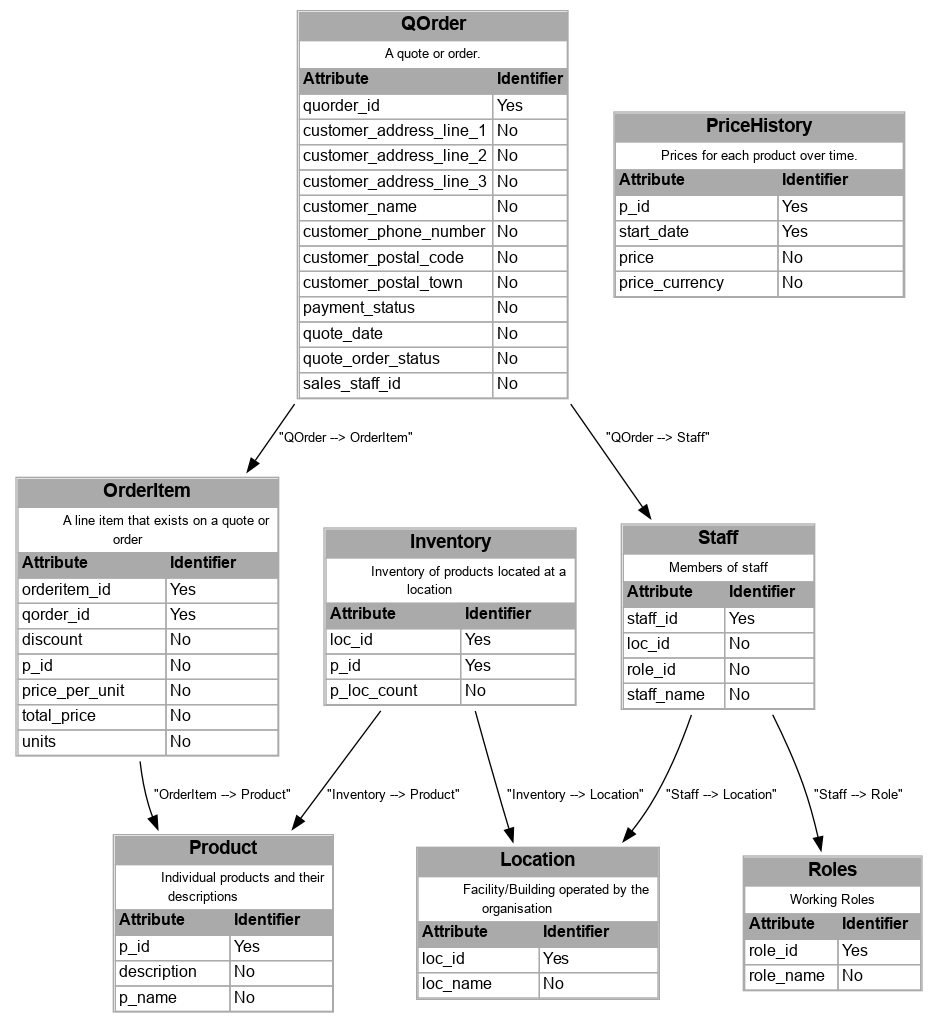

In [55]:
dot_text = DMEAR_vizdiff_to_dot(s1, s1)
print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

[('"No"', '"p_loc_count"'), ('"Yes"', '"p_id"'), ('"Yes"', '"loc_id"')]
#000000
#000000
#000000
Inventory BLACK
[('"No"', '"price_per_unit"'), ('"No"', '"discount"'), ('"Yes"', '"orderitem_id"'), ('"No"', '"units"'), ('"No"', '"total_price"'), ('"No"', '"p_id"'), ('"Yes"', '"qorder_id"')]
#000000
#000000
#000000
#000000
#000000
#000000
#000000
OrderItem BLACK
[('"No"', '"role_name"'), ('"Yes"', '"role_id"')]
#000000
#000000
Roles BLACK
[('"Yes"', '"p_id"'), ('"No"', '"price"'), ('"No"', '"price_currency"'), ('"Yes"', '"start_date"')]
#000000
#000000
#000000
#000000
PriceHistory BLACK
[('"Yes"', '"loc_id"'), ('"No"', '"loc_name"')]
#000000
#000000
Location BLACK
[('"No"', '"p_name"'), ('"Yes"', '"p_id"'), ('"No"', '"description"')]
#000000
#000000
#000000
Product BLACK
[('"Yes"', '"staff_id"'), ('"No"', '"role_id"'), ('"No"', '"staff_name"'), ('"No"', '"loc_id"')]
#000000
#000000
#000000
#000000
Staff BLACK
[('"No"', '"sales_staff_id"'), ('"No"', '"customer_id"'), ('"No"', '"quote_date"

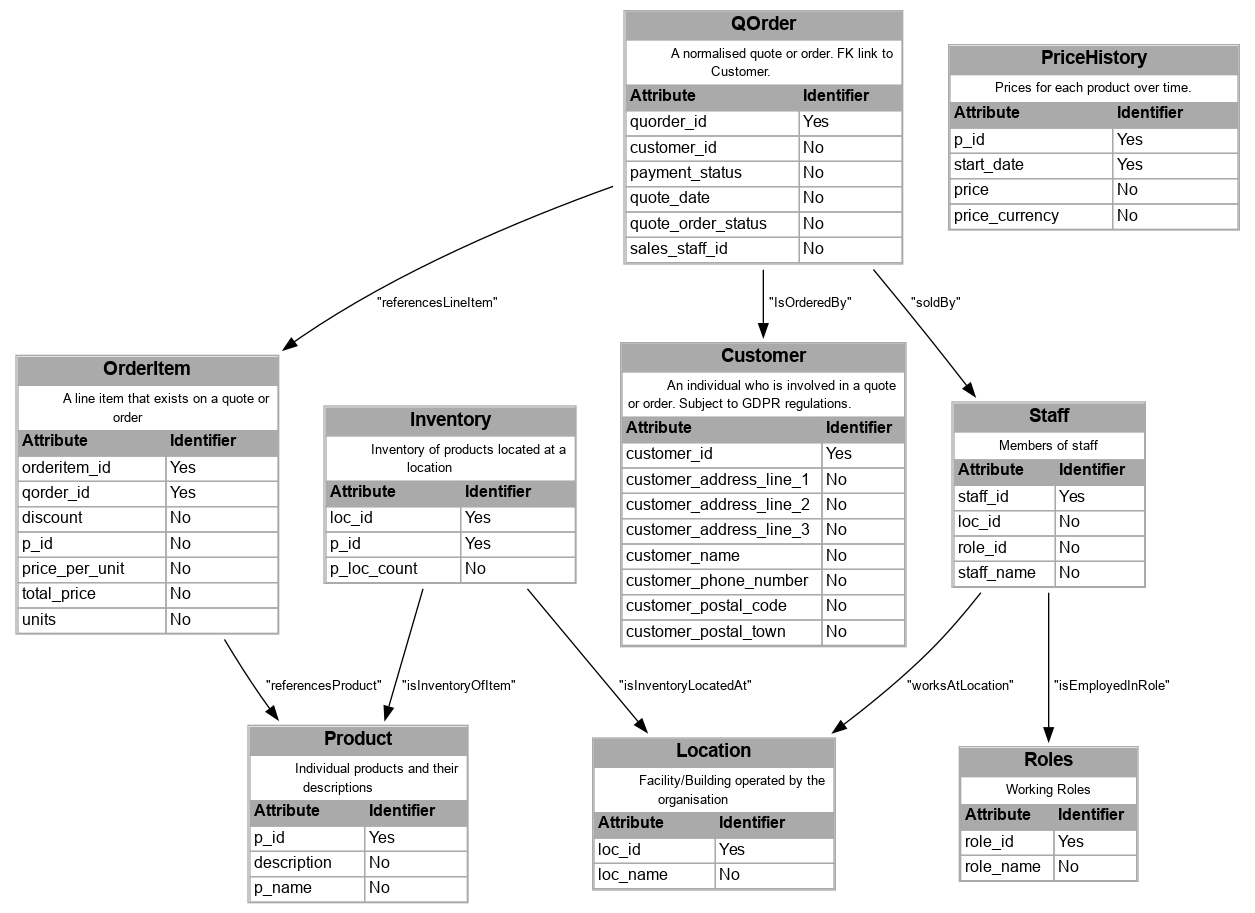

In [56]:
dot_text = DMEAR_vizdiff_to_dot(s2, s2)
print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

[('"Yes"', '"p_id"'), ('"No"', '"p_loc_count"'), ('"Yes"', '"loc_id"')]
#000000
#000000
#000000
Inventory BLACK
[('"No"', '"units"'), ('"No"', '"total_price"'), ('"No"', '"price_per_unit"'), ('"No"', '"discount"'), ('"Yes"', '"orderitem_id"'), ('"No"', '"p_id"'), ('"Yes"', '"qorder_id"')]
#000000
#000000
#000000
#000000
#000000
#000000
#000000
OrderItem BLACK
[('"Yes"', '"role_id"'), ('"No"', '"role_name"')]
#000000
#000000
Roles BLACK
[('"Yes"', '"p_id"'), ('"No"', '"price_currency"'), ('"Yes"', '"start_date"'), ('"No"', '"price"')]
#000000
#000000
#000000
#000000
PriceHistory BLACK
[('"No"', '"loc_name"'), ('"Yes"', '"loc_id"')]
#000000
#000000
Location BLACK
[('"No"', '"p_name"'), ('"Yes"', '"p_id"'), ('"No"', '"description"')]
#000000
#000000
#000000
Product BLACK
[('"No"', '"role_id"'), ('"No"', '"loc_id"'), ('"Yes"', '"staff_id"'), ('"No"', '"staff_name"')]
#000000
#000000
#000000
#000000
Staff BLACK
[('"No"', '"customer_postal_code"'), ('"No"', '"customer_address_line_1"'), ('"N

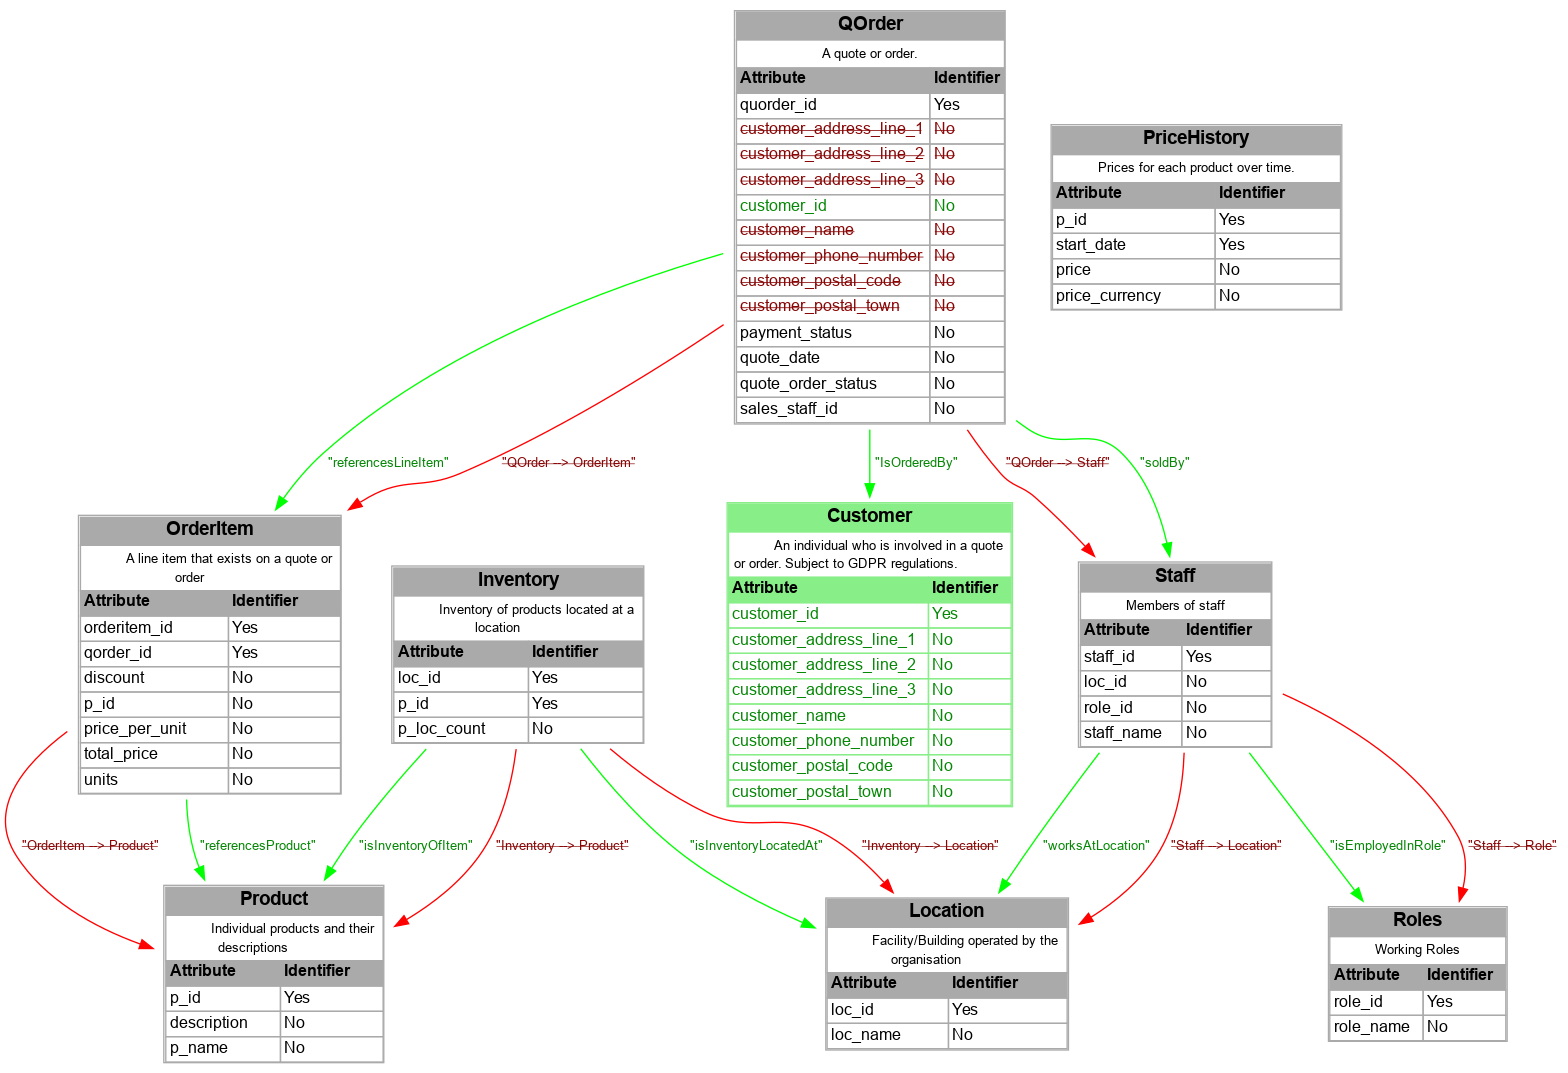

In [57]:
dot_text = DMEAR_vizdiff_to_dot(s1, s2)
print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [58]:
timestamp = datetime.now()

elapsed = timestamp - start
print(elapsed)

0:03:56.263237


[('"No"', '"p_loc_count"'), ('"Yes"', '"p_id"'), ('"Yes"', '"loc_id"')]
#000000
#000000
#000000
Inventory BLACK
[('"No"', '"price_per_unit"'), ('"No"', '"discount"'), ('"Yes"', '"orderitem_id"'), ('"No"', '"units"'), ('"No"', '"total_price"'), ('"No"', '"p_id"'), ('"Yes"', '"qorder_id"')]
#000000
#000000
#000000
#000000
#000000
#000000
#000000
OrderItem BLACK
[('"No"', '"role_name"'), ('"Yes"', '"role_id"')]
#000000
#000000
Roles BLACK
[('"Yes"', '"p_id"'), ('"No"', '"price"'), ('"No"', '"price_currency"'), ('"Yes"', '"start_date"')]
#000000
#000000
#000000
#000000
PriceHistory BLACK
[('"Yes"', '"loc_id"'), ('"No"', '"loc_name"')]
#000000
#000000
Location BLACK
[('"No"', '"p_name"'), ('"Yes"', '"p_id"'), ('"No"', '"description"')]
#000000
#000000
#000000
Product BLACK
[('"Yes"', '"staff_id"'), ('"No"', '"role_id"'), ('"No"', '"staff_name"'), ('"No"', '"loc_id"')]
#000000
#000000
#000000
#000000
Staff BLACK
[('"No"', '"sales_staff_id"'), ('"No"', '"customer_id"'), ('"No"', '"quote_date"

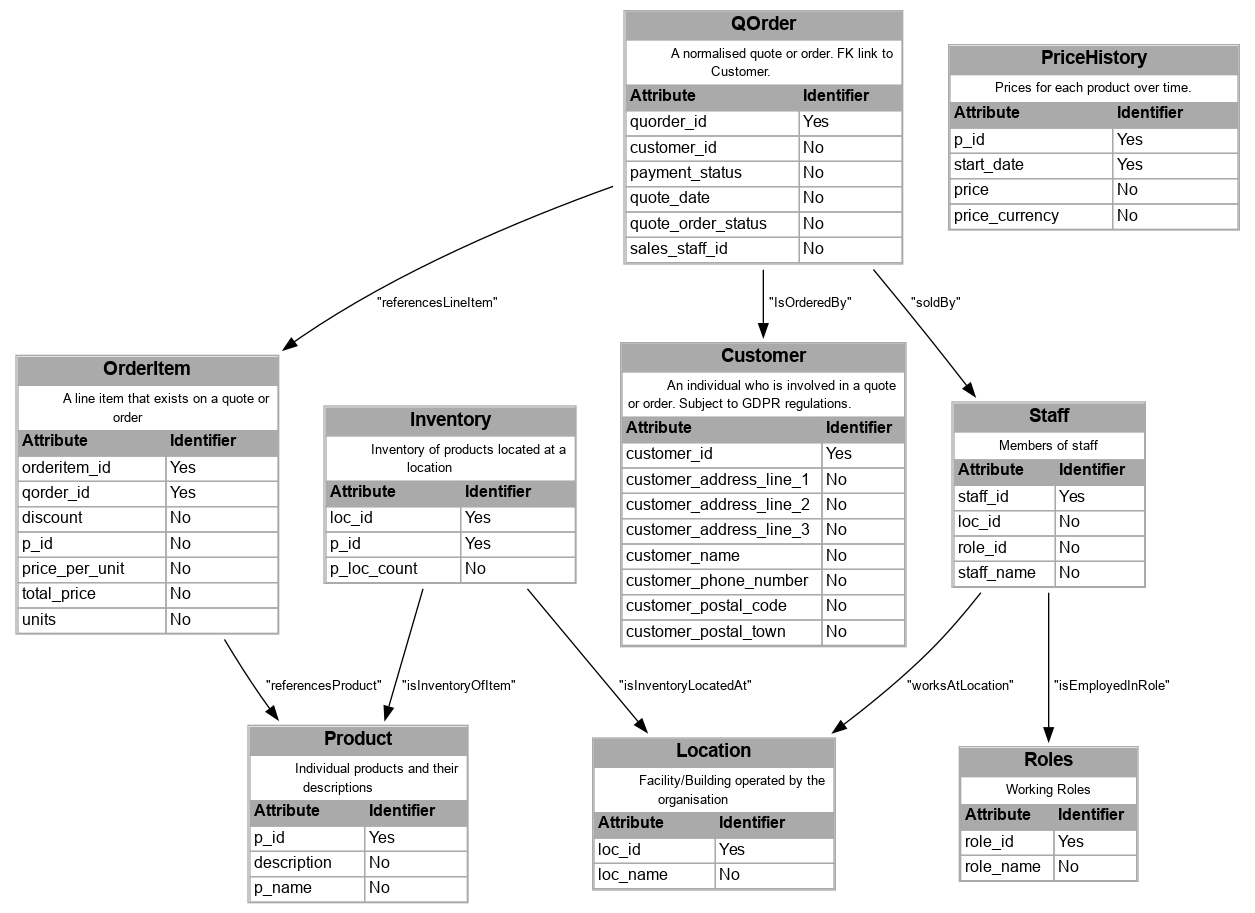

In [59]:
dot_text = DMEAR_vizdiff_to_dot(s2, s2)
print(dot_text)
dg = pydotplus.graph_from_dot_data(dot_text)
png = dg.create_png()
display(Image(png))

In [60]:
import difflib

In [61]:
a = "Mary had a little lamb. Its fleece as white as snow."
b = "Sue had a little puppy. Its eyes as dark as night."

In [62]:
diffs = difflib.SequenceMatcher(None, a,b)

In [63]:
diffs.a

'Mary had a little lamb. Its fleece as white as snow.'

In [64]:
diffs.b

'Sue had a little puppy. Its eyes as dark as night.'

In [65]:
from IPython.display import display
from IPython.display import HTML

In [66]:
output=""
for c, i1, i2, j1, j2 in diffs.get_opcodes():
    if c in ["replace", "delete"]:
        print(c, b[j1:j2])
        output=output+"<font color=\"red\"><s>"+a[i1:i2]+"</s></font>"+"<font color=\"green\">" + b[j1:j2]+"</font>"
    elif c in "insert":
        print(c, b[j1:j2])
        output=output+"<font color=\"green\">" + b[j1:j2]+"</font>"
    else:
        print(c, b[j1:j2])
        output=output+b[j1:j2]
        
display(HTML(output))
        

replace Sue
equal  had a little 
replace puppy
equal . Its 
delete 
equal e
insert y
equal e
replace s
equal  as 
replace dark
equal  as 
delete 
equal n
replace ight
equal .


In [67]:
a = "This text starts the same. And ends the same way."
b = "This text starts the same, but includes a section that deviates from the original before ending the same way."

In [68]:
diffs = difflib.SequenceMatcher(None, a,b)

output=""
for c, i1, i2, j1, j2 in diffs.get_opcodes():
    if c in ["replace", "delete"]:
        print(c, b[j1:j2])
        output=output+"<font color=\"red\"><s>"+a[i1:i2]+"</s></font>"+"<font color=\"green\">" + b[j1:j2]+"</font>"
    elif c in "insert":
        print(c, b[j1:j2])
        output=output+"<font color=\"green\">" + b[j1:j2]+"</font>"
    else:
        print(c, b[j1:j2])
        output=output+b[j1:j2]
        
display(HTML(output))
        

equal This text starts the same
replace ,
equal  
replace but i
equal n
insert clu
equal d
insert es a section that deviates from the original before
equal  end
replace ing
equal  the same way.


In [69]:
diffs.get_opcodes()

[('equal', 0, 25, 0, 25),
 ('replace', 25, 26, 25, 26),
 ('equal', 26, 27, 26, 27),
 ('replace', 27, 28, 27, 32),
 ('equal', 28, 29, 32, 33),
 ('insert', 29, 29, 33, 36),
 ('equal', 29, 30, 36, 37),
 ('insert', 30, 30, 37, 88),
 ('equal', 30, 34, 88, 92),
 ('replace', 34, 35, 92, 95),
 ('equal', 35, 49, 95, 109)]

In [1]:
import difflib difflib.get_close_matches(i,)